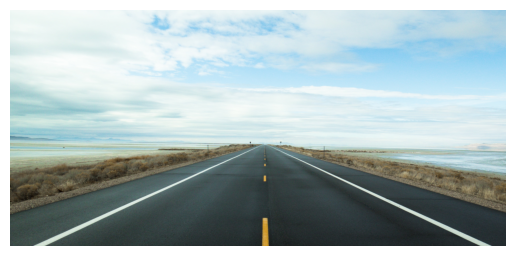

In [21]:
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np

url = "https://c1.wallpaperflare.com/path/334/646/514/road-horizon-path-travel-66a1c7411565d2992ca1b988b223c04d.jpg"
# Download and save the image
img_path = "downloaded_image.png"
with open(img_path, "wb") as f:
    f.write(requests.get(url).content)

# Read the image normally
img = cv2.imread(img_path)

# Convert BGR to RGB and display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


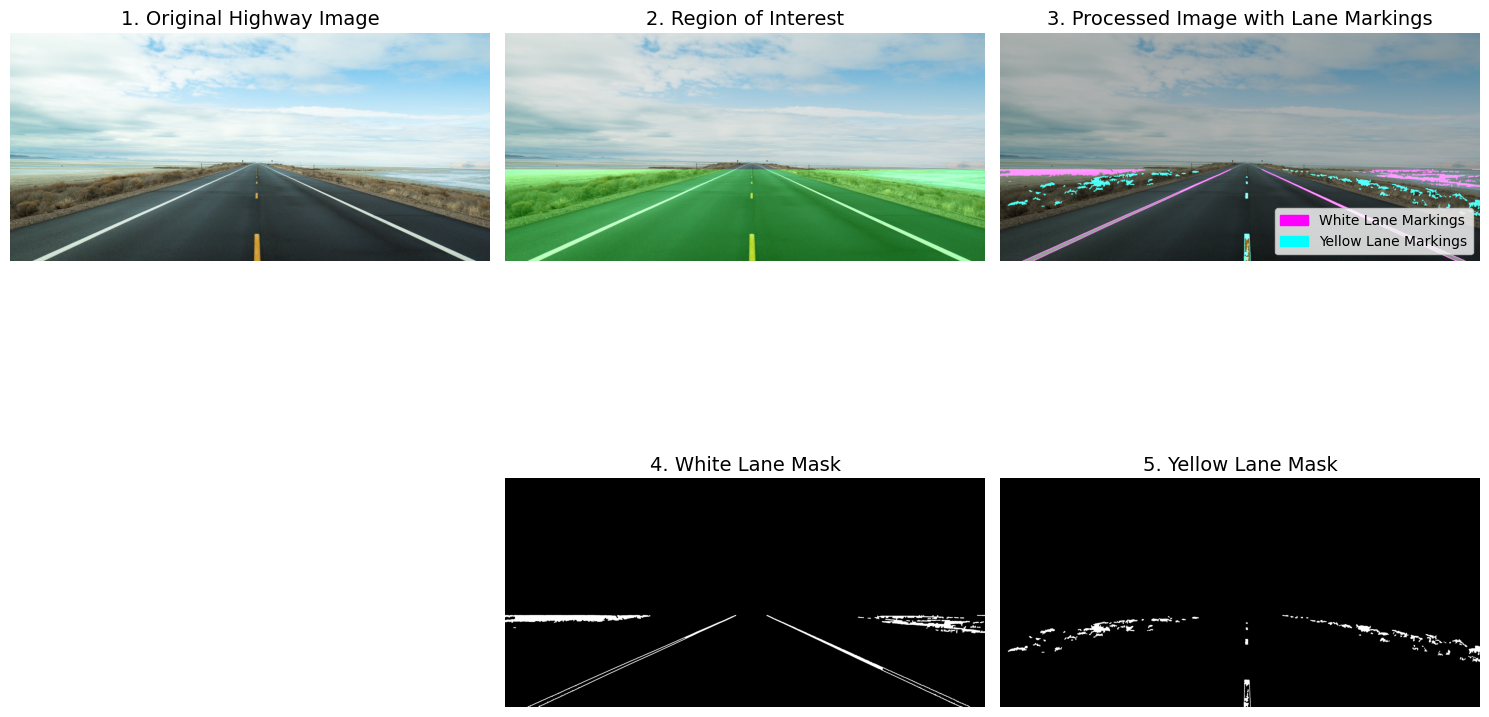

Lane marking extraction completed successfully!
Output files:
1. lane_detection_results.png - Main results with images
2. white_lane_mask.png - Binary mask for white lane markings
3. yellow_lane_mask.png - Binary mask for yellow lane markings
4. processed_image.png - Original image with highlighted lane markings
5. roi_display.png - Image showing the region of interest


In [25]:
def extract_lane_markings(image_path):
    """
    Extracts white and yellow lane markings from a highway image using
    traditional image processing techniques with a region of interest mask.

    Args:
        image_path (str): Path to the input highway image

    Returns:
        tuple: (original_img, processed_img, white_mask, yellow_mask)
    """
    # Read the image
    image = cv2.imread(image_path)

    # Check if image is loaded properly
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    # Convert to RGB (from BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get dimensions
    height, width = image_rgb.shape[:2]

    # Create a region of interest (ROI) mask to focus only on the road
    # and ignore the sky and other irrelevant parts
    roi_mask = np.zeros((height, width), dtype=np.uint8)

    # Define the polygon for the ROI (bottom half of the image as a trapezoid)
    # These values may need adjustment based on your specific image
    roi_corners = np.array([
        [(0, height), (0, height*0.6), (width, height*0.6), (width, height)]
    ], dtype=np.int32)

    # Fill the ROI polygon
    cv2.fillPoly(roi_mask, roi_corners, 255)

    # Convert to HSV color space for better color segmentation
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # Define color ranges for white and yellow in HSV
    # White color range
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])

    # Yellow color range
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([35, 255, 255])

    # Create masks for white and yellow colors
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Apply the ROI mask to both color masks
    white_mask = cv2.bitwise_and(white_mask, white_mask, mask=roi_mask)
    yellow_mask = cv2.bitwise_and(yellow_mask, yellow_mask, mask=roi_mask)

    # Apply Gaussian blur to reduce noise
    white_mask = cv2.GaussianBlur(white_mask, (5, 5), 0)
    yellow_mask = cv2.GaussianBlur(yellow_mask, (5, 5), 0)

    # Apply Canny edge detection
    white_edges = cv2.Canny(white_mask, 50, 150)
    yellow_edges = cv2.Canny(yellow_mask, 50, 150)

    # Apply morphological operations to enhance lane markings
    kernel = np.ones((5, 5), np.uint8)

    # Dilation to connect nearby edges
    white_dilated = cv2.dilate(white_edges, kernel, iterations=1)
    yellow_dilated = cv2.dilate(yellow_edges, kernel, iterations=1)

    # Close gaps in the lane markings
    white_closed = cv2.morphologyEx(white_dilated, cv2.MORPH_CLOSE, kernel)
    yellow_closed = cv2.morphologyEx(yellow_dilated, cv2.MORPH_CLOSE, kernel)

    # Create final masks
    final_white_mask = np.zeros_like(white_mask)
    final_yellow_mask = np.zeros_like(yellow_mask)

    # Find contours in the binary images
    white_contours, _ = cv2.findContours(white_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    yellow_contours, _ = cv2.findContours(yellow_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by area to remove small noise
    min_contour_area = 100

    for contour in white_contours:
        if cv2.contourArea(contour) > min_contour_area:
            cv2.drawContours(final_white_mask, [contour], -1, 255, -1)

    for contour in yellow_contours:
        if cv2.contourArea(contour) > min_contour_area:
            cv2.drawContours(final_yellow_mask, [contour], -1, 255, -1)

    # Create a highlighted version of the original image with distinctive colors
    highlighted_image = np.copy(image_rgb)

    # Apply distinctive color for white lanes (magenta)
    white_lane = np.zeros_like(image_rgb)
    white_lane[final_white_mask > 0] = [255, 0, 255]  # Magenta for white lanes

    # Apply distinctive color for yellow lanes (cyan)
    yellow_lane = np.zeros_like(image_rgb)
    yellow_lane[final_yellow_mask > 0] = [0, 255, 255]  # Cyan for yellow lanes

    # Combine white and yellow lanes
    lane_overlay = cv2.addWeighted(white_lane, 1, yellow_lane, 1, 0)

    # Combine with original image with higher overlay weight for more visibility
    highlighted_image = cv2.addWeighted(highlighted_image, 0.7, lane_overlay, 0.8, 0)

    # Create binary masks with proper colors for output
    output_white_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=np.uint8)
    output_white_mask[final_white_mask > 0] = 255

    output_yellow_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=np.uint8)
    output_yellow_mask[final_yellow_mask > 0] = 255

    ## For debugging: Create an image showing the ROI
    roi_display = np.copy(image_rgb)
    roi_display_mask = np.zeros_like(image_rgb)
    roi_display_mask[roi_mask > 0] = [0, 255, 0]  # Green for ROI
    roi_display = cv2.addWeighted(roi_display, 0.9, roi_display_mask, 0.3, 0)

    return image_rgb, highlighted_image, output_white_mask, output_yellow_mask, roi_display

def display_images(original, processed, white_mask, yellow_mask, roi_display):
    """
    Displays the original image, processed image, white mask, yellow mask, and ROI
    with a legend for the distinctive colors used

    Args:
        original: Original RGB image
        processed: Processed image with lane markings highlighted
        white_mask: Binary mask for white lane markings
        yellow_mask: Binary mask for yellow lane markings
        roi_display: Image showing the region of interest
    """
    plt.figure(figsize=(15, 10))

    # 1. Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(original)
    plt.title('1. Original Highway Image', fontsize=14)
    plt.axis('off')

    # 2. ROI Display
    plt.subplot(2, 3, 2)
    plt.imshow(roi_display)
    plt.title('2. Region of Interest', fontsize=14)
    plt.axis('off')

    # 3. Processed Image with highlighted lane markings
    plt.subplot(2, 3, 3)
    plt.imshow(processed)
    plt.title('3. Processed Image with Lane Markings', fontsize=14)

    # Add color legend patches to the processed image
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, color='magenta', label='White Lane Markings'),
        plt.Rectangle((0, 0), 1, 1, color='cyan', label='Yellow Lane Markings')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=10)
    plt.axis('off')

    # 4. White Lane Mask
    plt.subplot(2, 3, 5)
    plt.imshow(white_mask, cmap='gray')
    plt.title('4. White Lane Mask', fontsize=14)
    plt.axis('off')

    # 5. Yellow Lane Mask
    plt.subplot(2, 3, 6)
    plt.imshow(yellow_mask, cmap='gray')
    plt.title('5. Yellow Lane Mask', fontsize=14)
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('lane_detection_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    try:
        # Extract lane markings
        original, processed, white_mask, yellow_mask, roi_display = extract_lane_markings(img_path)

        # Display images
        display_images(original, processed, white_mask, yellow_mask, roi_display)

        # Save the masks and processed image
        cv2.imwrite('white_lane_mask.png', white_mask)
        cv2.imwrite('yellow_lane_mask.png', yellow_mask)
        cv2.imwrite('processed_image.png', cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))
        cv2.imwrite('roi_display.png', cv2.cvtColor(roi_display, cv2.COLOR_RGB2BGR))

        print("Lane marking extraction completed successfully!")
        print("Output files:")
        print("1. lane_detection_results.png - Main results with images")
        print("2. white_lane_mask.png - Binary mask for white lane markings")
        print("3. yellow_lane_mask.png - Binary mask for yellow lane markings")
        print("4. processed_image.png - Original image with highlighted lane markings")
        print("5. roi_display.png - Image showing the region of interest")

    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()